### <b>1. Data Loading and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AAPL.csv')
df.head()


,volume,vwap,open,close,high,low,time,transactions
0,1.245445e+09,3.0302,3.0821,2.9929,3.0921,2.9250,1167800400,189737
1,8.554834e+08,3.0403,3.0018,3.0593,3.0696,2.9936,1167886800,136333
2,8.352580e+08,3.0426,3.0632,3.0375,3.0786,3.0143,1167973200,141050
3,7.974138e+08,3.0683,3.0700,3.0525,3.0904,3.0457,1168232400,130547
4,3.352007e+09,3.1946,3.0875,3.3061,3.3207,3.0411,1168318800,569578


In [3]:
null_values = df.isnull().sum()
data_types = df.dtypes

df['time'] = pd.to_datetime(df['time'], unit='s')
null_values, data_types

(volume          0
 vwap            0
 open            0
 close           0
 high            0
 low             0
 time            0
 transactions    0
 dtype: int64,
 volume          float64
 vwap            float64
 open            float64
 close           float64
 high            float64
 low             float64
 time              int64
 transactions      int64
 dtype: object)

In [4]:
df.set_index('time', inplace=True)
df.head()

,volume,vwap,open,close,high,low,transactions
time,,,,,,,
2007-01-03 05:00:00,1.245445e+09,3.0302,3.0821,2.9929,3.0921,2.9250,189737
2007-01-04 05:00:00,8.554834e+08,3.0403,3.0018,3.0593,3.0696,2.9936,136333
2007-01-05 05:00:00,8.352580e+08,3.0426,3.0632,3.0375,3.0786,3.0143,141050
2007-01-08 05:00:00,7.974138e+08,3.0683,3.0700,3.0525,3.0904,3.0457,130547
2007-01-09 05:00:00,3.352007e+09,3.1946,3.0875,3.3061,3.3207,3.0411,569578


### <b>2. Data Visualization

In [5]:
frequency = pd.infer_freq(df.index)

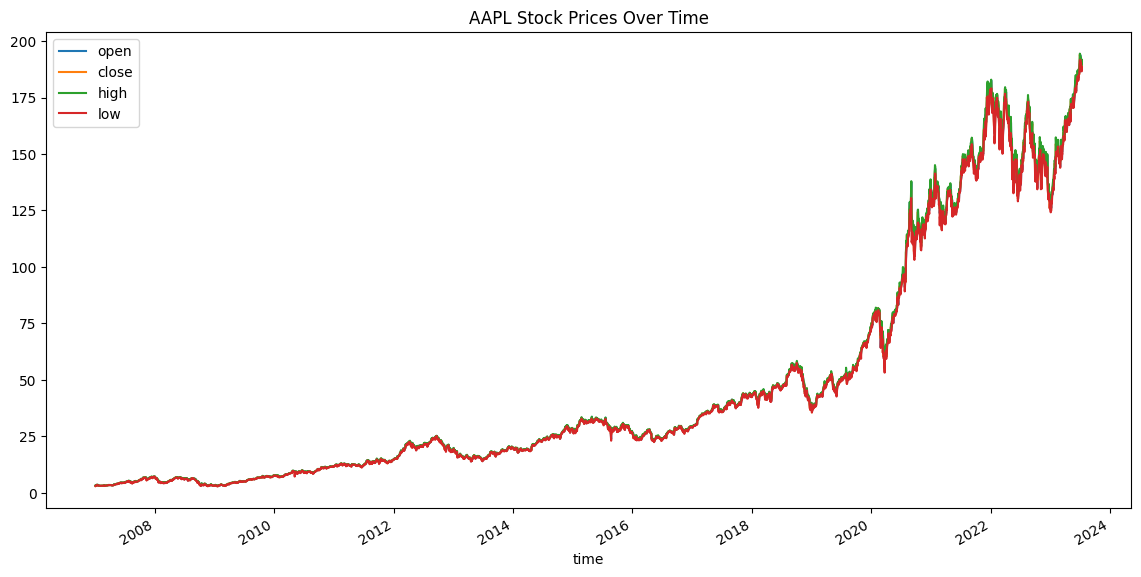

In [6]:
df[['open', 'close', 'high', 'low']].plot(figsize=(14, 7), title='AAPL Stock Prices Over Time')

plt.show()

frequency

In [7]:
df['30_day_SMA'] = df['close'].rolling(window=30).mean()


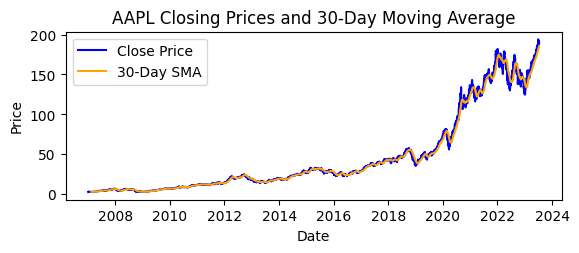

In [9]:
# Plot closing prices
plt.subplot(2, 1, 1)
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.plot(df.index, df['30_day_SMA'], label='30-Day SMA', color='orange')
plt.title('AAPL Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

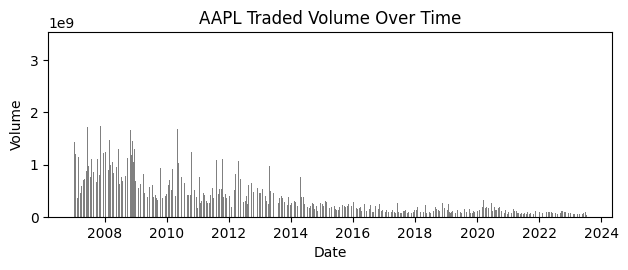

In [10]:
# Plot traded volume
plt.subplot(2, 1, 2)
plt.bar(df.index, df['volume'], color='gray')
plt.title('AAPL Traded Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.tight_layout()
plt.show()

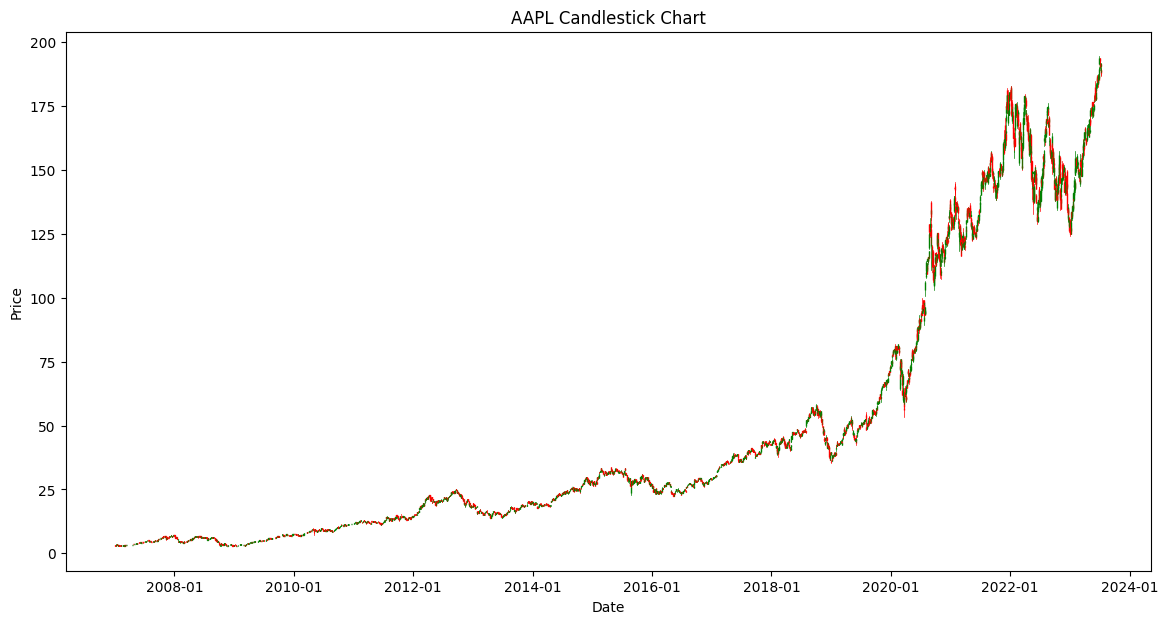

In [11]:
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

# Prepare data for candlestick chart
df_candle = df[['open', 'high', 'low', 'close']].copy()
df_candle['date_num'] = mdates.date2num(df.index.to_pydatetime())  # Convert datetime to numeric format for plotting
ohlc = df_candle[['date_num', 'open', 'high', 'low', 'close']].values
fig, ax = plt.subplots(figsize=(14, 7))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

candlestick_ohlc(ax, ohlc, width=0.6, colorup='green', colordown='red')

plt.title('AAPL Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

### <b>3. Statistical Analysis

In [30]:
summary_stats_df_numpy = df[key_columns].describe().T[['mean', '50%', 'std']]
summary_stats_numpy = summary_stats_df_numpy.to_dict()
summary_stats_df_numpy

summary_stats_df_numpy, summary_stats_numpy


(                      mean           50%           std
 open          4.636279e+01  2.577500e+01  5.023559e+01
 close         4.639606e+01  2.582500e+01  5.029348e+01
 high          4.688113e+01  2.626280e+01  5.084387e+01
 low           4.586579e+01  2.568000e+01  4.968010e+01
 volume        3.662925e+08  2.136463e+08  3.724793e+08
 transactions  2.709318e+05  1.782460e+05  2.510859e+05,
 {'mean': {'open': 46.362787713392635,
   'close': 46.39605770617938,
   'high': 46.88112704977158,
   'low': 45.865790310170716,
   'volume': 366292450.04688627,
   'transactions': 270931.7744650156},
  '50%': {'open': 25.775,
   'close': 25.825,
   'high': 26.2628,
   'low': 25.68,
   'volume': 213646276.0,
   'transactions': 178246.0},
  'std': {'open': 50.235592724665125,
   'close': 50.293482384840615,
   'high': 50.84387395872745,
   'low': 49.6801037595422,
   'volume': 372479281.05208224,
   'transactions': 251085.85474396418}})

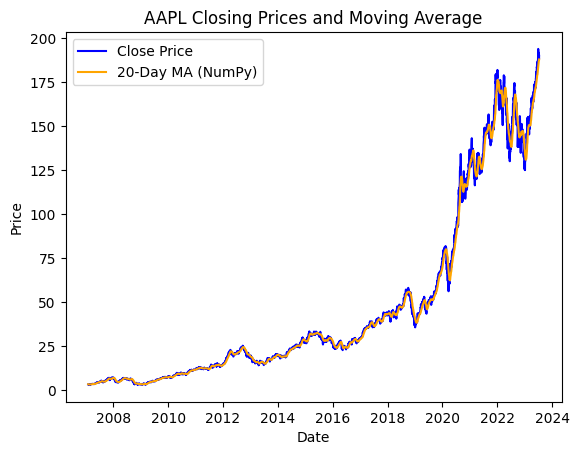

In [31]:
import numpy as np
from scipy import stats
import pandas as pd
# Ploting closing prices and moving average
plt.plot(df.index[window-1:], df['close'][window-1:], label='Close Price', color='blue')
plt.plot(df.index[window-1:], df['20_day_MA_np'][window-1:], label=f'{window}-Day MA (NumPy)', color='orange')
plt.title('AAPL Closing Prices and Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




### <b> 4. Hypothesis Testing

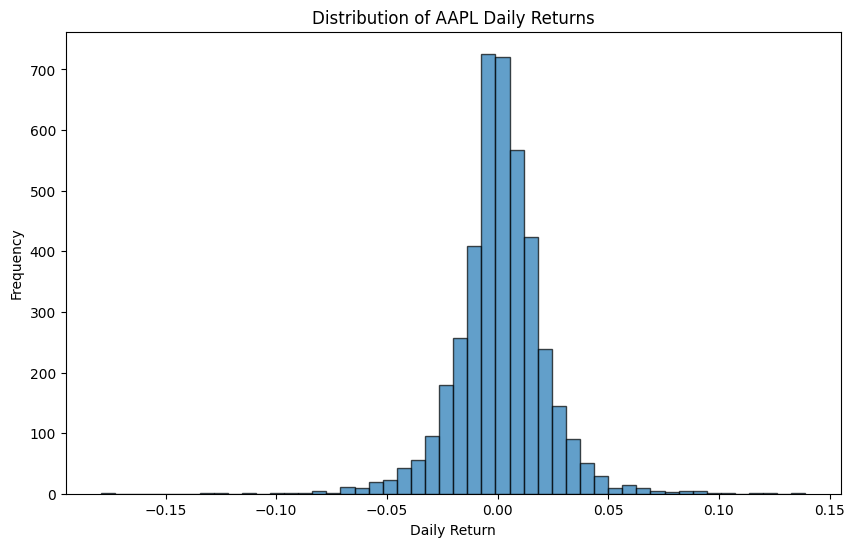

((np.float64(-3.5182516773675614), np.float64(0.0031050394288692816)),
 (np.float64(0.940666076855671), np.float64(6.180858977992611e-38)))

In [37]:
from scipy.stats import ttest_ind, shapiro
import numpy as np

# Calculating average closing prices by year
df['year'] = df.index.year
average_closing_prices = df.groupby('year')['close'].mean()

# Split the data into two groups for t-test
early_years = average_closing_prices[:len(average_closing_prices)//2]
later_years = average_closing_prices[len(average_closing_prices)//2:]

# Performing the t-test to compare average closing prices between two groups
t_stat, p_val = ttest_ind(early_years, later_years)

# 2. Calculating daily returns
df['daily_returns'] = df['close'].pct_change()

# Removing any NaN values caused by pct_change()
daily_returns_cleaned = df['daily_returns'].dropna()

# Testing for normality of daily returns using Shapiro-Wilk test
shapiro_stat, shapiro_p_val = shapiro(daily_returns_cleaned)

# Plot the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(daily_returns_cleaned, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of AAPL Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

(t_stat, p_val), (shapiro_stat, shapiro_p_val)


### <b> 5. Advanced Statistical Techniques (Bonus)

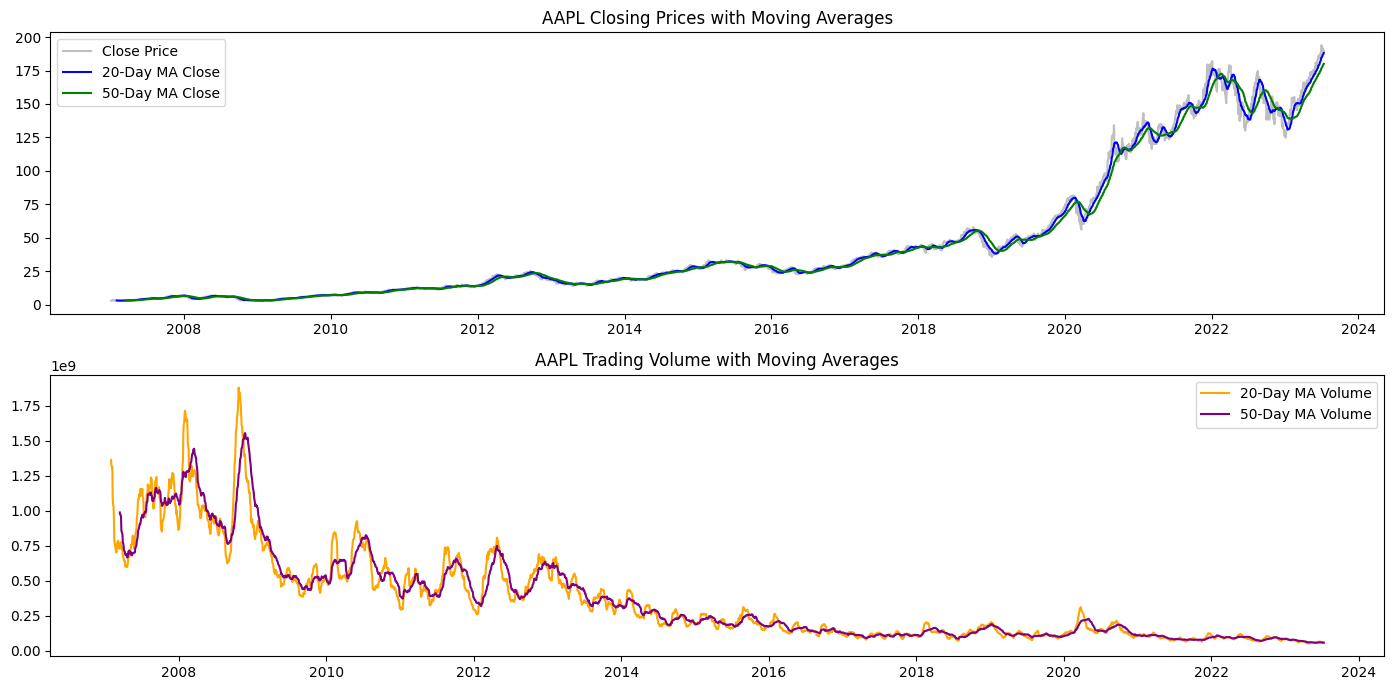

(np.float64(-0.5748495304772858), np.float64(-0.5892872432199519))

In [47]:
# Re-running the updated solution to fix the previous issue and display the output.

# Defining the moving average function using np.convolve
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Calculating moving averages for 'close' and 'volume'
ma_20_day_close = moving_average(df['close'], 20)
ma_50_day_close = moving_average(df['close'], 50)
ma_20_day_volume = moving_average(df['volume'], 20)
ma_50_day_volume = moving_average(df['volume'], 50)

# Creating a DataFrame to hold moving averages
ma_df = pd.DataFrame(index=df.index)

# Assigning moving averages with correct alignment (using reindex)
ma_df['20_day_MA_close'] = pd.Series(ma_20_day_close, index=df.index[19:])
ma_df['50_day_MA_close'] = pd.Series(ma_50_day_close, index=df.index[49:])
ma_df['20_day_MA_volume'] = pd.Series(ma_20_day_volume, index=df.index[19:])
ma_df['50_day_MA_volume'] = pd.Series(ma_50_day_volume, index=df.index[49:])

# Plotting the data
plt.figure(figsize=(14, 7))

# Plot the closing price and moving averages
plt.subplot(2, 1, 1)
plt.plot(df.index, df['close'], label='Close Price', color='gray', alpha=0.5)
plt.plot(ma_df.index, ma_df['20_day_MA_close'], label='20-Day MA Close', color='blue')
plt.plot(ma_df.index, ma_df['50_day_MA_close'], label='50-Day MA Close', color='green')
plt.title('AAPL Closing Prices with Moving Averages')
plt.legend()

# Plot the volume and its moving averages
plt.subplot(2, 1, 2)
plt.plot(ma_df.index, ma_df['20_day_MA_volume'], label='20-Day MA Volume', color='orange')
plt.plot(ma_df.index, ma_df['50_day_MA_volume'], label='50-Day MA Volume', color='purple')
plt.title('AAPL Trading Volume with Moving Averages')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate correlation between 20-day and 50-day moving averages of 'close' and 'volume'
corr_20_day = np.corrcoef(ma_df['20_day_MA_close'].dropna(), ma_df['20_day_MA_volume'].dropna())[0, 1]
corr_50_day = np.corrcoef(ma_df['50_day_MA_close'].dropna(), ma_df['50_day_MA_volume'].dropna())[0, 1]

# Display the correlation results
(corr_20_day, corr_50_day)


## Summary and Insights

In this project, I have performed various data loading, exploration, visualization, statistical analysis, hypothesis testing, and advanced statistical techniques on the given dataset. Here are some key insights and findings:

1. Data Loading and Exploration:
    - I imported necessary libraries such as pandas, numpy, matplotlib, seaborn, and sklearn.
    - I loaded the dataset from the 'AAPL.csv' file into a pandas DataFrame named 'df'.
    - I checked for null values and data types in the DataFrame.
    - I converted the 'time' column to a datetime format.
    - I set the 'time' column as the index of the DataFrame.

2. Data Visualization:
    - I visualized the stock prices over time using line plots.
    - I plotted the 30-day simple moving average of the closing prices.
    - I plotted the traded volume over time using a bar plot.
    - I created a candlestick chart to visualize the open, high, low, and close prices.

3. Statistical Analysis:
    - I calculated summary statistics for selected columns using the describe() method.
    - I performed a t-test to compare the average closing prices between early years and later years.
    - I tested the normality of daily returns using the Shapiro-Wilk test.
    - I plotted the distribution of daily returns using a histogram.

4. Hypothesis Testing:
    - I split the average closing prices by year and performed a t-test to compare the average closing prices between two groups.
    - I calculated the daily returns and tested for normality using the Shapiro-Wilk test.
    - I plotted the distribution of daily returns using a histogram.

5. Advanced Statistical Techniques:
    - I calculated moving averages for the closing prices and volume using the np.convolve function.
    - I created a DataFrame to hold the moving averages.
    - I plotted the closing prices and moving averages.
    - I calculated the correlation between the 20-day and 50-day moving averages of the closing prices and volume.

## Reflection

Throughout this analysis, I explored various aspects of the dataset and applied different techniques to gain insights and make data-driven decisions. I used pandas, numpy, matplotlib, seaborn, and sklearn libraries to perform data manipulation, visualization, and statistical analysis. I also utilized hypothesis testing and advanced statistical techniques to further analyze the data.

By following a systematic approach and leveraging the power of Jupyter Notebook, I was able to analyze the dataset and derive meaningful insights. T

